# Práctica 2 - CNNs

### Natalia Martínez García, Lucía Vega Navarrete
### Grupo: AP.11.06

In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import visualkeras
from keras import layers, models, regularizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [12]:
seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

### 1. Carga del dataset

In [13]:
# Cargamos el dataset STL-10 ya dividido en entrenamiento y test
(train, test), info_ds = tfds.load(
    'stl10',
    split=['train', 'test'],
    as_supervised=True,  # devuelve tuplas (imagen, etiqueta)
    with_info=True # devuelve info extra del dataset (número de clases, tamaño de imagen, etc.)
)

num_clases = info_ds.features['label'].num_classes
nombres_clases = info_ds.features['label'].names
tamano_imagen = info_ds.features['image'].shape
dimension_entrada = np.prod(tamano_imagen)

print("\n" + "="*50)
print("INFORMACIÓN DEL DATASET")
print("="*50)

print(f"NOMBRE: {info_ds.name}")
print(f"\nIMÁGENES:")
print(f" - Dimensiones: {tamano_imagen}")
print(f" - Tipo: {info_ds.features['image'].numpy_dtype}")
print(f" - Longitud aplanada: {dimension_entrada}")


print(f"\nETIQUETAS:")
print(f" - Número de clases: {num_clases}")
print(f" - Clases: {', '.join(nombres_clases)}")

print(f"\nSPLITS:")
print(f" - Train: {info_ds.splits['train'].num_examples:,} imágenes")
print(f" - Test: {info_ds.splits['test'].num_examples:,} imágenes")
print(f" - Unlabelled: {info_ds.splits['unlabelled'].num_examples:,} imágenes (NO LOS USAMOS)")


INFORMACIÓN DEL DATASET
NOMBRE: stl10

IMÁGENES:
 - Dimensiones: (96, 96, 3)
 - Tipo: <class 'numpy.uint8'>
 - Longitud aplanada: 27648

ETIQUETAS:
 - Número de clases: 10
 - Clases: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

SPLITS:
 - Train: 5,000 imágenes
 - Test: 8,000 imágenes
 - Unlabelled: 100,000 imágenes (NO LOS USAMOS)


### 2. Preprocesado

Reutilizamos código de la práctrica anterior. Al tener que presentar las imágenes como un mapa bidimensional, eliminamos la línea conde las aplanamos y las mantenemos en su forma original.
Como antes teníamos las imágenes aplanadas, usábamos `np.array()` para pasarlo a numpy. Ahora como tenemos las dimansiones originales, tenemos que usar `tf.stack()`

In [12]:
def preprocesado(imagen, etiqueta):
    imagen = tf.cast(imagen, tf.float32) / 255.0  # imagen a float32 y escala [0,1]
    etiqueta = tf.one_hot(etiqueta, depth = num_clases) # one-hot encoding
    return imagen, etiqueta

def preprocesado_dataset(dataset):
    # Creamos listas vacías donde almacenaremos las imágenes y etiquetas preprocesadas.
    imagenes = []
    etiquetas = []

    for img, label in dataset:
        imagen, etiqueta = preprocesado(img, label) # Aplicamos el preprocesado a cada muestra
        # Añadimos los resultafos a las listas
        imagenes.append(imagen)
        etiquetas.append(etiqueta)

    # Convertimos a arrays de numpy (manteniendo las 3 dimensiones)
    return tf.stack(imagenes).numpy(), tf.stack(etiquetas).numpy()

# Aplicamos la funcion a los conjuntos de entrenamiento y test
train_inputs, train_targets = preprocesado_dataset(train)
test_inputs, test_targets = preprocesado_dataset(test)


print("Shape de train_inputs:", train_inputs.shape)
print("Shape de train_targets:", train_targets.shape)

Shape de train_inputs: (5000, 96, 96, 3)
Shape de train_targets: (5000, 10)


####  División del dataset

In [13]:
# Permutación aleatoria de índices para mezclar los datos
# Para que la división train/validation sea aleatoria
indices_permutation = np.random.permutation(len(train_inputs))
shuffled_inputs = train_inputs[indices_permutation]
shuffled_targets = train_targets[indices_permutation]

# Calculamos cuántas muestras coger para validación (20% del de entrenamiento)
num_validation_samples = int(0.2 * len(train_inputs))

# Separamos el primer 20% para validación
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
# El resto se mantiene para entrenamiento
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

### 3. Creación y entrenamiento de modelos

In [14]:
def entrenar(modelo, train, val, test, epochs=15):

    # Desempaquetamos los conjuntos de datos
    train_x, train_y = train
    val_x, val_y = val
    test_x, test_y = test

    # Entrenamos el modelo
    history = modelo.fit(
        train_x, train_y,
        validation_data=(val_x, val_y),
        epochs=epochs,
        batch_size=128
    )

    # Evaluamos el modelo en test y mostramos resultados
    loss, acc, prec, rec, f1 = modelo.evaluate(test_x, test_y, verbose=0)

    print("\nResultados en TEST:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")

    return history, loss, acc, prec, rec, f1

In [15]:
def plot(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    # Crear figura con 2 subplots lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfica de accuracy
    ax1.plot(epochs, accuracy, "b-o", label="Training accuracy")
    ax1.plot(epochs, val_accuracy, "r--o", label="Validation accuracy")
    ax1.set_title("Training and validation accuracy")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Gráfica de loss
    ax2.plot(epochs, loss, "b-o", label="Training loss")
    ax2.plot(epochs, val_loss, "r--o", label="Validation loss")
    ax2.set_title("Training and validation loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

#### 3.1. Modelo 1 - CNN base


In [34]:
# copié el ejemplo del lab 6 del punto 6.4.1, vamos cambiando cosas luego
def cnn_base(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    cnn_base = models.Model(inputs, outputs, name="cnn_base")
    return cnn_base

# Construcción con TUS variables
cnn_base = cnn_base(tamano_imagen,num_clases)

# Si quieres, después le añades tus métricas de Precision/Recall/F1.
cnn_base.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

cnn_base.summary()


Model: "cnn_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.1628 - f1_score: 0.1226 - loss: 2.2390 - precision: 0.1911 - recall: 0.0016 - val_accuracy: 0.2760 - val_f1_score: 0.2208 - val_loss: 1.9284 - val_precision: 0.4755 - val_recall: 0.0970
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.3491 - f1_score: 0.3276 - loss: 1.7332 - precision: 0.6666 - recall: 0.1156 - val_accuracy: 0.3530 - val_f1_score: 0.3277 - val_loss: 1.7237 - val_precision: 0.5919 - val_recall: 0.1320
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.4229 - f1_score: 0.3937 - loss: 1.5761 - precision: 0.6922 - recall: 0.1662 - val_accuracy: 0.4140 - val_f1_score: 0.4008 - val_loss: 1.5808 - val_precision: 0.6129 - val_recall: 0.1900
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.4866 - f1_score: 0.4705 - loss: 1.4369 - precision: 0.7347 - recall: 0.2471 - val_accuracy: 0.4240 - val_f1_score: 0.4125 - val_loss: 1.5533 - val_precision: 0.6186 - val_recall: 0

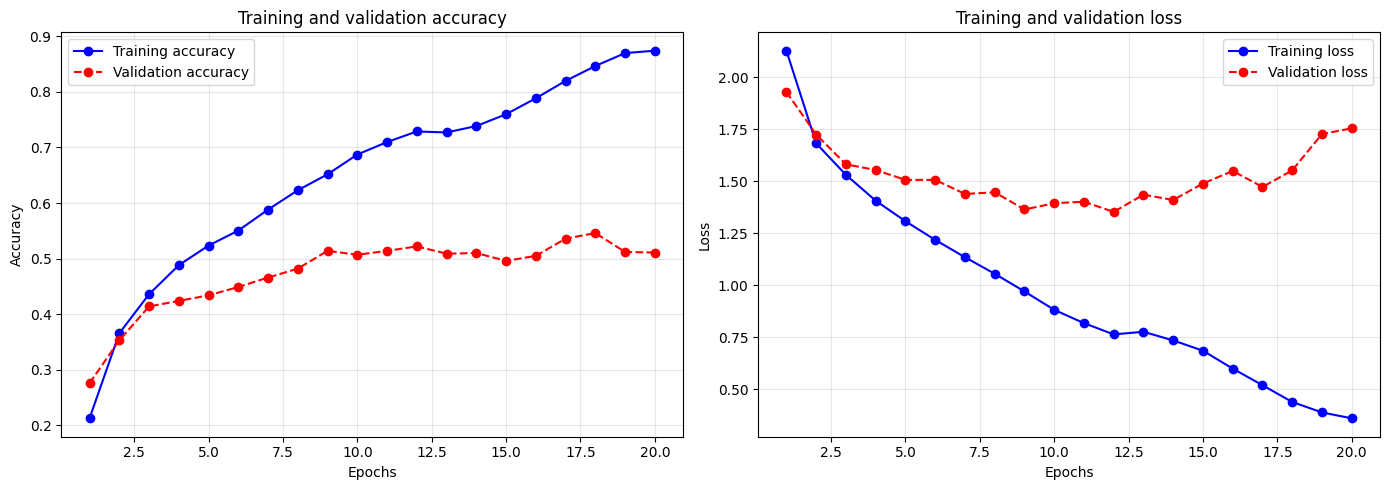

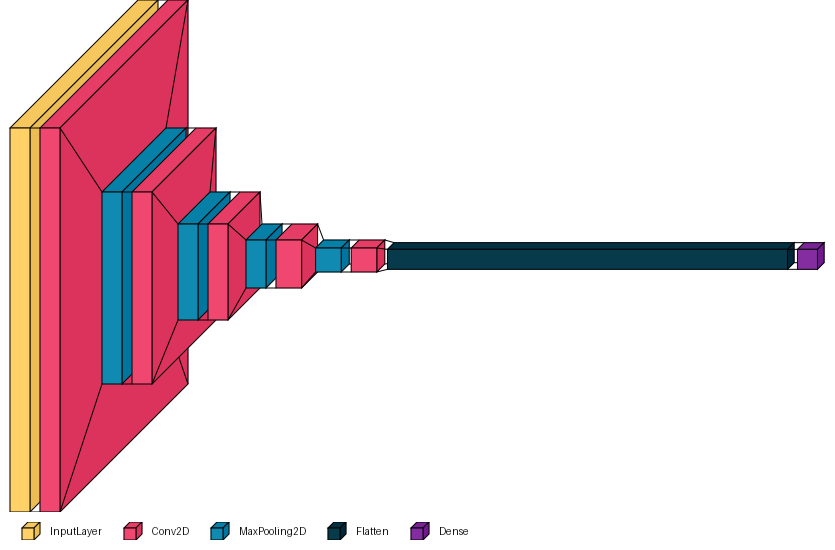

In [35]:
hist_base, loss_base, acc_base, prec_base, rec_base, f1_base= entrenar(
    cnn_base,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 20
)

plot(hist_base)
visualkeras.layered_view(cnn_base, legend=True)

In [53]:
# copié el ejemplo del lab 6 del punto 6.4.1, vamos cambiando cosas luego
def cnn_base(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    cnn_base = models.Model(inputs, outputs, name="cnn_base")
    return cnn_base

# Construcción con TUS variables
cnn_base = cnn_base(tamano_imagen,num_clases)

# Si quieres, después le añades tus métricas de Precision/Recall/F1.
cnn_base.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

cnn_base.summary()


Model: "cnn_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.1344 - f1_score: 0.0958 - loss: 2.2482 - precision: 0.2128 - recall: 0.0015 - val_accuracy: 0.2510 - val_f1_score: 0.1966 - val_loss: 2.0891 - val_precision: 0.4311 - val_recall: 0.0720
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3259 - f1_score: 0.2928 - loss: 1.8457 - precision: 0.6389 - recall: 0.0829 - val_accuracy: 0.3120 - val_f1_score: 0.2800 - val_loss: 1.8417 - val_precision: 0.5157 - val_recall: 0.1480
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.4049 - f1_score: 0.3795 - loss: 1.6236 - precision: 0.6747 - recall: 0.1625 - val_accuracy: 0.3780 - val_f1_score: 0.3620 - val_loss: 1.6554 - val_precision: 0.5600 - val_recall: 0.1820
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4563 - f1_score: 0.4388 - loss: 1.4913 - precision: 0.6975 - recall: 0.2284 - val_accuracy: 0.4240 - val_f1_score: 0.4074 - val_loss: 1.5814 - val_precision: 0.5977 - val_recall: 0

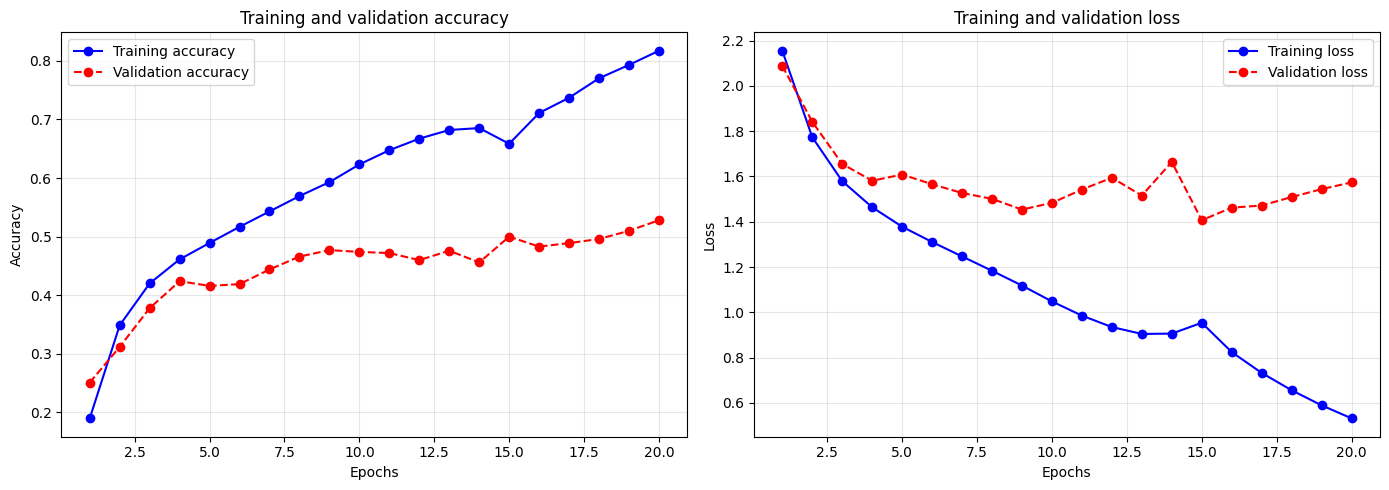

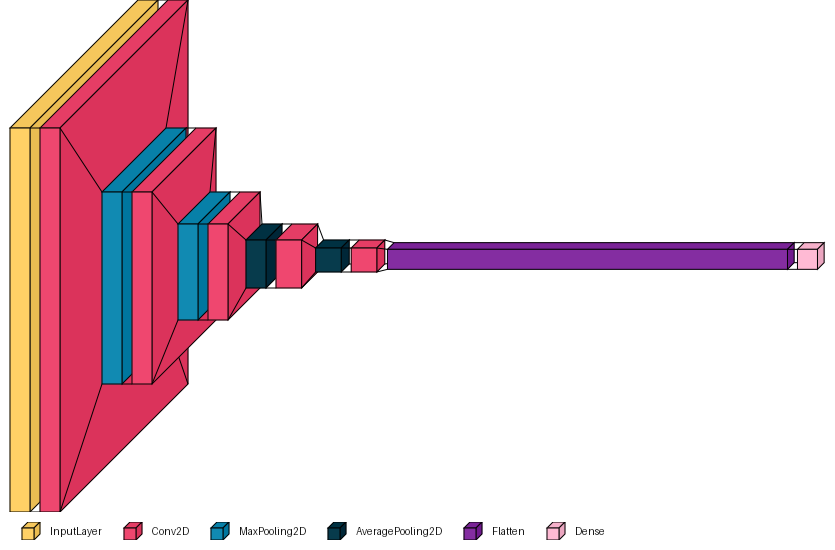

In [54]:
hist_base, loss_base, acc_base, prec_base, rec_base, f1_base= entrenar(
    cnn_base,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 20
)

plot(hist_base)
visualkeras.layered_view(cnn_base, legend=True)

#### 3.2 Modelo 2 - Data augmentation (ns si al añadirlo ya se considera otro modelo o hay que ponérselo al base y no contarlo)

In [59]:
# esto lo cogí del lab 6, pone en el enunciado que hagamos aumento de datos. esto lo aplica luego al ppo del modelo, despés del input
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [75]:
# SOLO DATA AUG SIN DROPOUT

# copié el ejemplo del lab 6 del punto 6.4.1, vamos cambiando cosas luego
def data_aug(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    data_aug = models.Model(inputs, outputs, name="data_augmentation")
    return data_aug

# Construcción con TUS variables
data_aug = data_aug(tamano_imagen,num_clases)

# Si quieres, después le añades tus métricas de Precision/Recall/F1.
data_aug.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

data_aug.summary()


Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_28            │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_29            │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.1402 - f1_score: 0.0879 - loss: 2.2514 - precision: 0.2089 - recall: 0.0010 - val_accuracy: 0.2440 - val_f1_score: 0.2023 - val_loss: 1.9912 - val_precision: 0.4490 - val_recall: 0.0220
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2940 - f1_score: 0.2515 - loss: 1.9291 - precision: 0.6038 - recall: 0.0361 - val_accuracy: 0.2870 - val_f1_score: 0.2507 - val_loss: 1.9004 - val_precision: 0.5806 - val_recall: 0.0900
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3690 - f1_score: 0.3380 - loss: 1.7712 - precision: 0.7129 - recall: 0.0810 - val_accuracy: 0.3110 - val_f1_score: 0.2748 - val_loss: 2.0705 - val_precision: 0.4232 - val_recall: 0.1680
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3947 - f1_score: 0.3671 - loss: 1.6859 - precision: 0.6712 - recall: 0.1386 - val_accuracy: 0.3420 - val_f1_score: 0.3026 - val_loss: 2.0214 - val_precision: 0.4941 - val_recall: 0.2

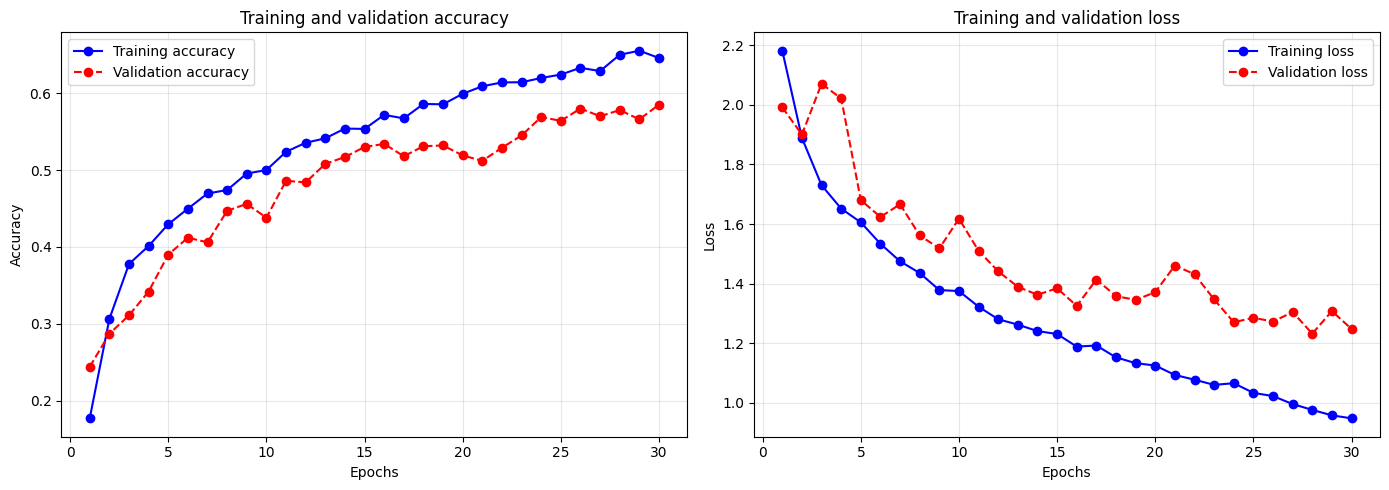

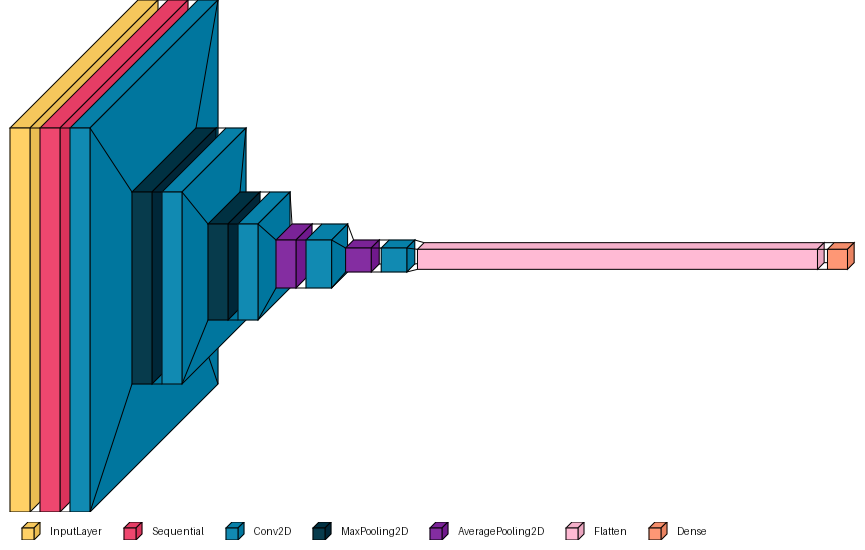

In [76]:
hist_data_aug, loss_data_aug, acc_data_aug, prec_data_aug, rec_data_aug, f1_data_aug= entrenar(
    data_aug,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 30
)

plot(hist_data_aug)
visualkeras.layered_view(data_aug, legend=True)

In [85]:
# AÑADIDO DROPOUT
def data_aug(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    data_aug = models.Model(inputs, outputs, name="data_augmentation")
    return data_aug

# Construcción con TUS variables
data_aug = data_aug(tamano_imagen,num_clases)

# Si quieres, después le añades tus métricas de Precision/Recall/F1.
data_aug.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

data_aug.summary()


Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_139 (Conv2D)             │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_35            │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_140 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_36            │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_141 (Conv2D)             │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.1231 - f1_score: 0.0808 - loss: 2.2663 - precision: 0.1372 - recall: 6.8739e-04 - val_accuracy: 0.1940 - val_f1_score: 0.1317 - val_loss: 2.1092 - val_precision: 0.5294 - val_recall: 0.0450
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2886 - f1_score: 0.2585 - loss: 1.9388 - precision: 0.6212 - recall: 0.0474 - val_accuracy: 0.2620 - val_f1_score: 0.2283 - val_loss: 2.0918 - val_precision: 0.3667 - val_recall: 0.1210
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3444 - f1_score: 0.3108 - loss: 1.7820 - precision: 0.6225 - recall: 0.0987 - val_accuracy: 0.3160 - val_f1_score: 0.2926 - val_loss: 2.0023 - val_precision: 0.4328 - val_recall: 0.1610
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3911 - f1_score: 0.3626 - loss: 1.6990 - precision: 0.6613 - recall: 0.1408 - val_accuracy: 0.3400 - val_f1_score: 0.3162 - val_loss: 1.8664 - val_precision: 0.4812 - val_recall:

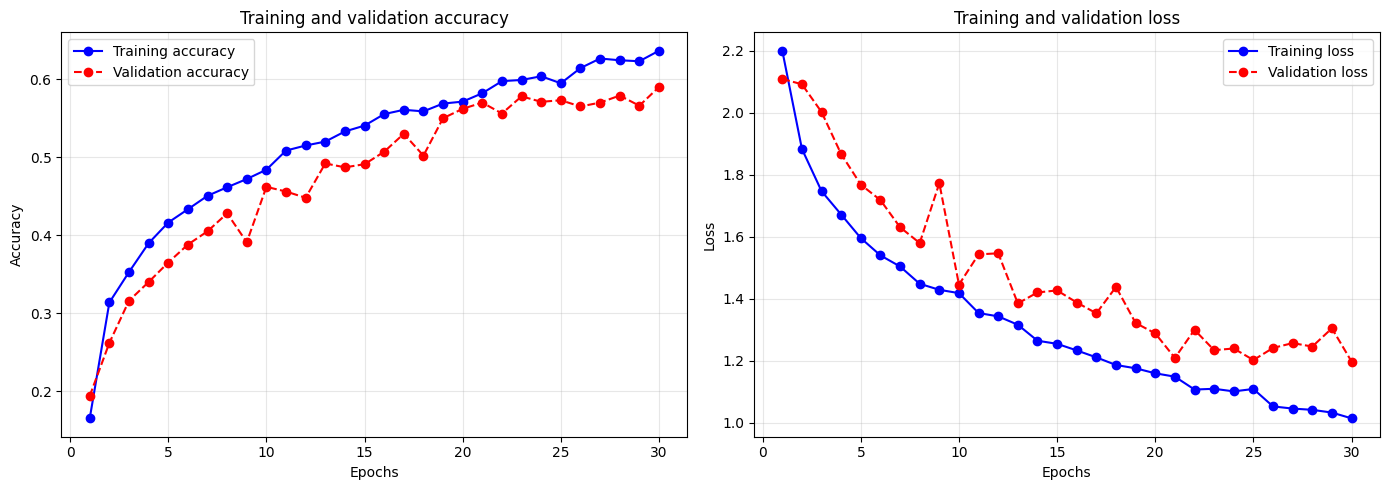

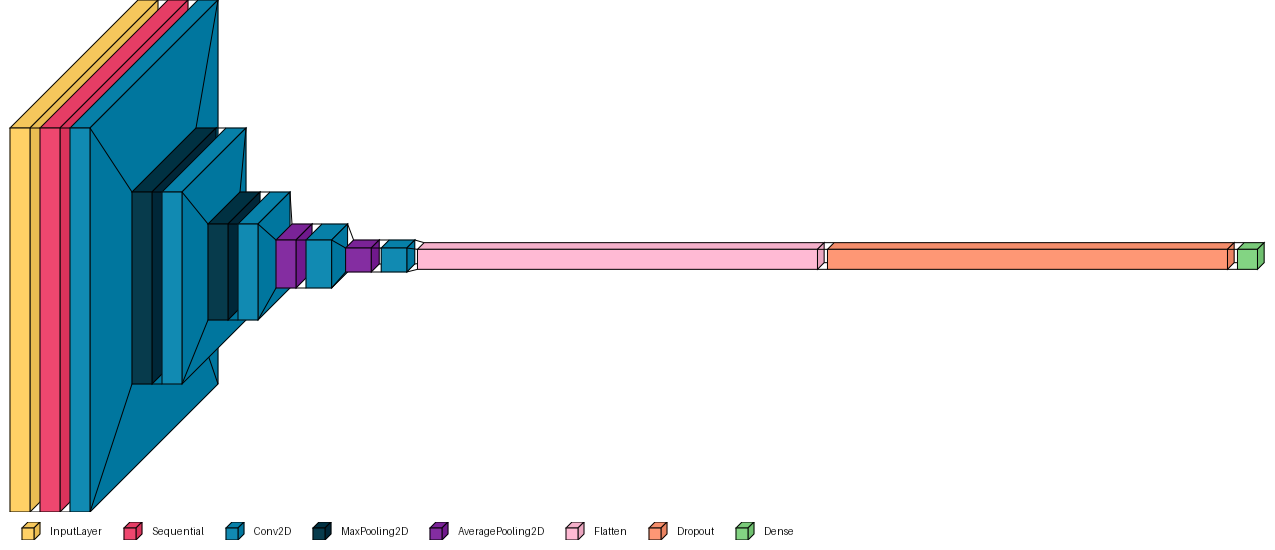

In [86]:
hist_data_aug, loss_data_aug, acc_data_aug, prec_data_aug, rec_data_aug, f1_data_aug= entrenar(
    data_aug,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 30
)

plot(hist_data_aug)
visualkeras.layered_view(data_aug, legend=True)

In [93]:
# cAÑADI ALGUNOS EPOCHS PORQUE PARECIA QUE SEGUIA APRENDIENDO PERO AHORA EMPEORA UN PCO PERO NS
def data_aug(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)   

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    data_aug = models.Model(inputs, outputs, name="data_augmentation")
    return data_aug

# Construcción con TUS variables
data_aug = data_aug(tamano_imagen,num_clases)

# Si quieres, después le añades tus métricas de Precision/Recall/F1.
data_aug.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

data_aug.summary()


Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_158 (Conv2D)             │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_159 (Conv2D)             │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_43            │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_160 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_44            │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_161 (Conv2D)             │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.1265 - f1_score: 0.0878 - loss: 2.2714 - precision: 0.1858 - recall: 9.1635e-04 - val_accuracy: 0.2190 - val_f1_score: 0.1670 - val_loss: 2.1168 - val_precision: 0.5128 - val_recall: 0.0600
Epoch 2/35
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2834 - f1_score: 0.2545 - loss: 1.9618 - precision: 0.6431 - recall: 0.0557 - val_accuracy: 0.2340 - val_f1_score: 0.1999 - val_loss: 2.2677 - val_precision: 0.3740 - val_recall: 0.1380
Epoch 3/35
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3340 - f1_score: 0.3032 - loss: 1.8168 - precision: 0.6227 - recall: 0.0929 - val_accuracy: 0.3080 - val_f1_score: 0.2751 - val_loss: 2.0115 - val_precision: 0.4441 - val_recall: 0.1590
Epoch 4/35
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3767 - f1_score: 0.3540 - loss: 1.7053 - precision: 0.6564 - recall: 0.1452 - val_accuracy: 0.3340 - val_f1_score: 0.3091 - val_loss: 1.8572 - val_precision: 0.4910 - val_recall:

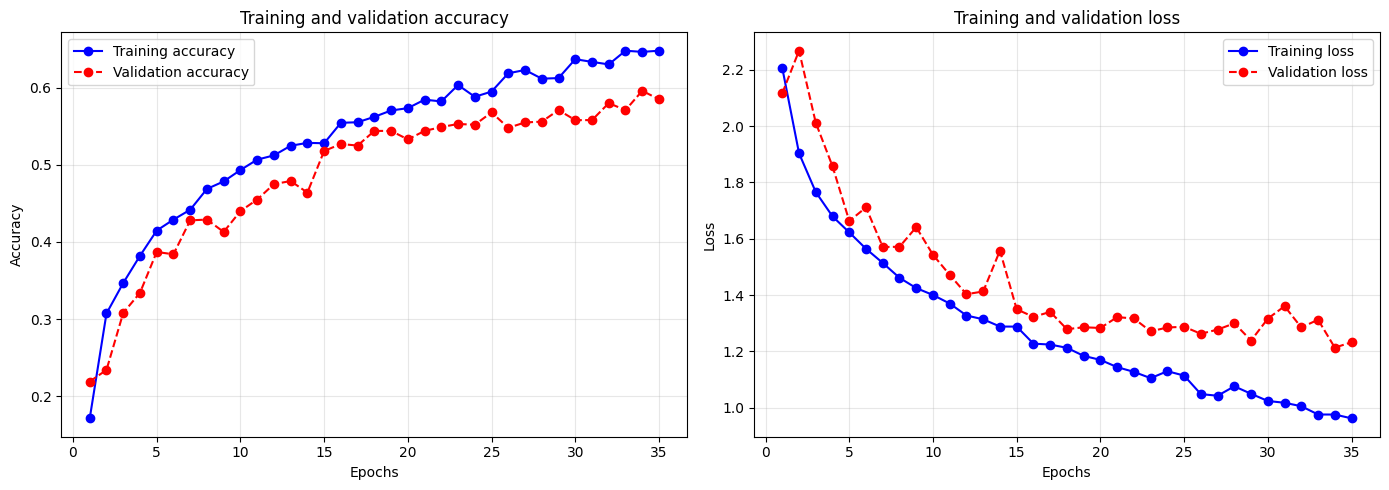

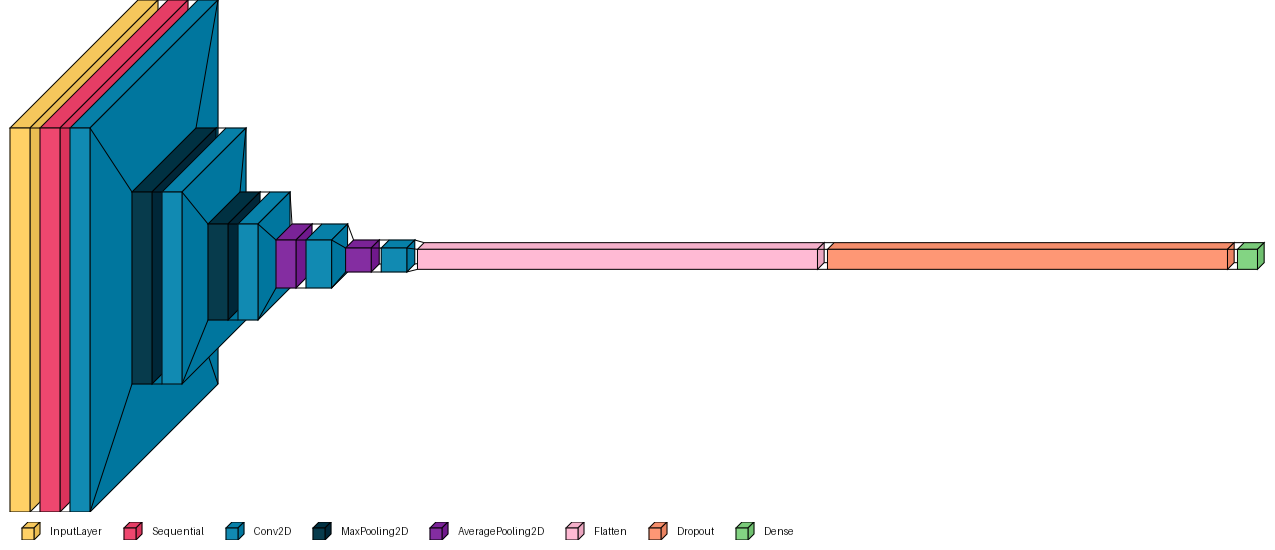

In [94]:
hist_data_aug, loss_data_aug, acc_data_aug, prec_data_aug, rec_data_aug, f1_data_aug= entrenar(
    data_aug,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 35
)

plot(hist_data_aug)
visualkeras.layered_view(data_aug, legend=True)

In [99]:
# ESTO LO PUSE PARA PROBAR EARLY STOPPING PERO CREO Q NO MERECE LA PENA USARLO
def entrenar(modelo, train, val, test, epochs=15, use_early_stopping=False,
             es_monitor='val_loss', es_patience=3, es_mode='min'):
    train_x, train_y = train
    val_x, val_y = val
    test_x, test_y = test

    callbacks = None
    if use_early_stopping:
        callbacks = [EarlyStopping(
            monitor=es_monitor,
            patience=es_patience,
            mode=es_mode,
            restore_best_weights=True,
            verbose=1
        )]


    history = modelo.fit(
        train_x, train_y,
        validation_data=(val_x, val_y),
        epochs=epochs,
        batch_size=128,
        callbacks=callbacks
    )

    loss, acc, prec, rec, f1 = modelo.evaluate(test_x, test_y, verbose=0)

    print("\nResultados en TEST:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")

    return history, loss, acc, prec, rec, f1

In [104]:
# copié el ejemplo del lab 6 del punto 6.4.1, vamos cambiando cosas luego
def data_aug(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    data_aug = models.Model(inputs, outputs, name="data_augmentation")
    return data_aug

# Construcción con TUS variables
data_aug = data_aug(tamano_imagen,num_clases)

# Si quieres, después le añades tus métricas de Precision/Recall/F1.
data_aug.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy',
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.F1Score(name='f1_score', average='macro')
])

data_aug.summary()


Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_172 (Conv2D)             │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_173 (Conv2D)             │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_174 (Conv2D)             │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_49            │ (None, 12, 12, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_175 (Conv2D)             │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_50            │ (None, 6, 6, 256)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 10)             │        92,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070,666 (4.08 MB)

 Trainable params: 1,070,666 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.1257 - f1_score: 0.0832 - loss: 2.2674 - precision: 0.1738 - recall: 6.8730e-04 - val_accuracy: 0.1910 - val_f1_score: 0.1237 - val_loss: 2.1607 - val_precision: 0.4679 - val_recall: 0.0510
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2798 - f1_score: 0.2416 - loss: 1.9575 - precision: 0.6018 - recall: 0.0405 - val_accuracy: 0.2830 - val_f1_score: 0.2558 - val_loss: 2.0103 - val_precision: 0.4420 - val_recall: 0.1410
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3600 - f1_score: 0.3318 - loss: 1.7433 - precision: 0.6520 - recall: 0.1231 - val_accuracy: 0.3120 - val_f1_score: 0.2869 - val_loss: 1.9485 - val_precision: 0.4935 - val_recall: 0.1510
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3933 - f1_score: 0.3713 - loss: 1.6933 - precision: 0.6707 - recall: 0.1300 - val_accuracy: 0.3490 - val_f1_score: 0.3300 - val_loss: 1.9381 - val_precision: 0.4787 - val_recall:

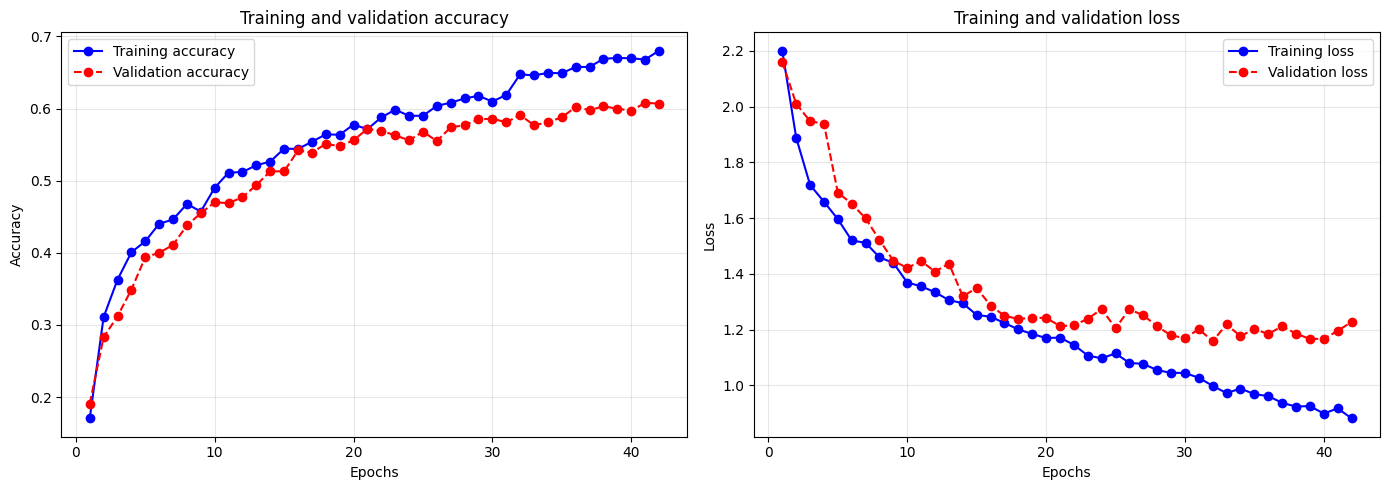

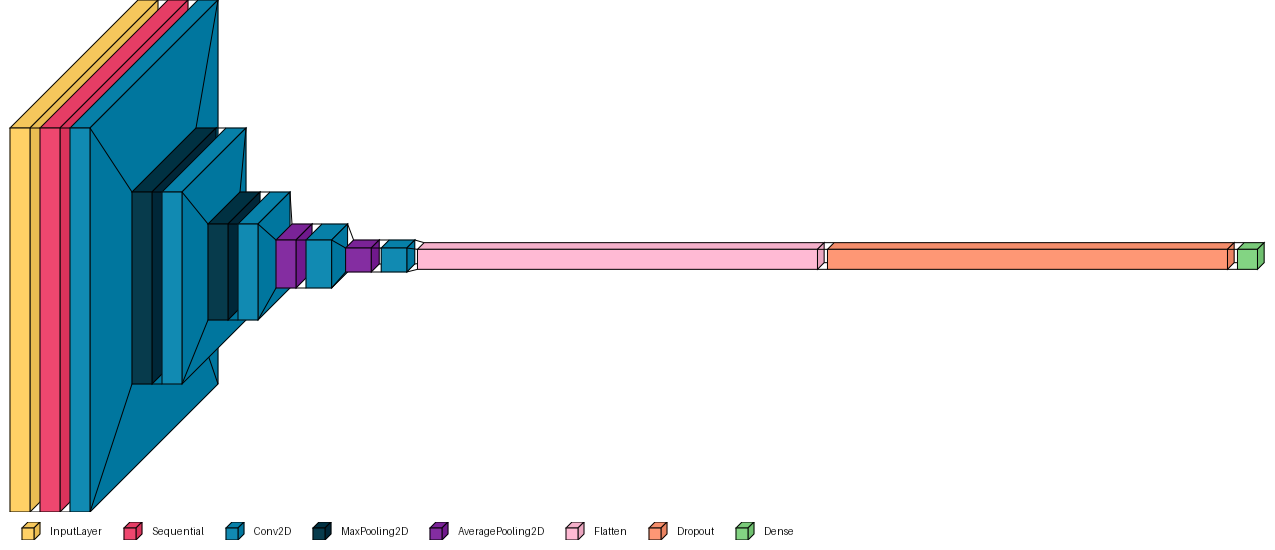

In [105]:
hist_data_aug, loss_data_aug, acc_data_aug, prec_data_aug, rec_data_aug, f1_data_aug= entrenar(
    data_aug,
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets), epochs = 50,
    use_early_stopping = True, es_patience = 10
)

plot(hist_data_aug)
visualkeras.layered_view(data_aug, legend=True)